In [24]:
#Group project

In [1]:
# import packages
library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)                                    # Install data.table
library("data.table")  
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')
#test1

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
train <- read_excel("data/Training_data.xls") %>% mutate(Class = as_factor(UNS))

In [3]:
train

STG,SCG,STR,LPR,PEG,UNS,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low,very_low
0.08,0.08,0.10,0.24,0.90,High,High
0.06,0.06,0.05,0.25,0.33,Low,Low
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High,High
0.50,0.75,0.81,0.61,0.26,Middle,Middle
0.66,0.90,0.76,0.87,0.74,High,High


In [4]:
# explore data
num_obs <- nrow(train)
train %>%
  group_by(Class) %>%
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )%>%
arrange(by=desc(percentage))

`summarise()` ungrouping output (override with `.groups` argument)



Class,count,percentage
<fct>,<int>,<dbl>
Middle,88,34.108527
Low,83,32.170543
High,63,24.418605
very_low,24,9.302326


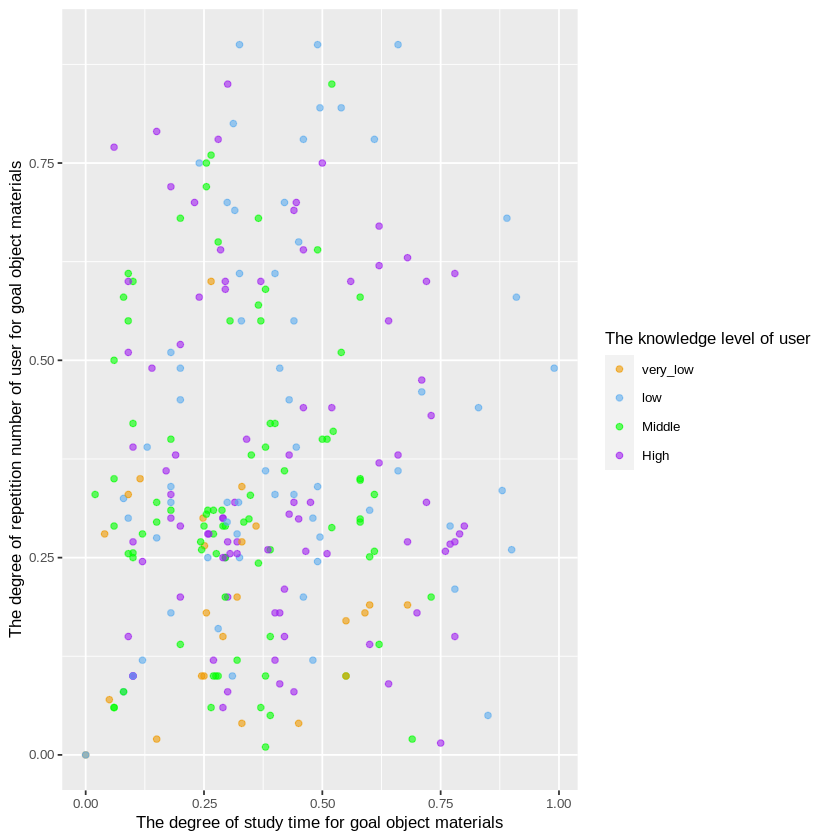

In [5]:
#scatter plot to visualize
perim_concav <- train %>%
  ggplot(aes(x = STG, y = SCG, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "The degree of study time for goal object materials", 
       y = "The degree of repetition number of user for goal object materials",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 10))
perim_concav

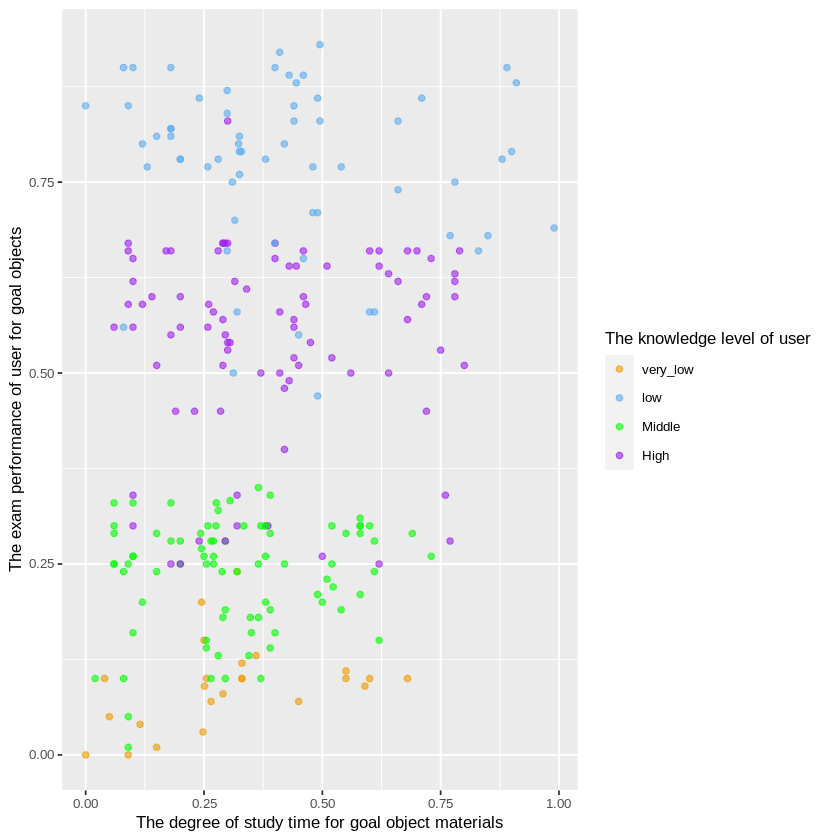

In [6]:
perim_concav_2 <- train %>%
  ggplot(aes(x = STG, y = PEG, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "The degree of study time for goal object materials", 
       y = "The exam performance of user for goal objects",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 10))
perim_concav_2

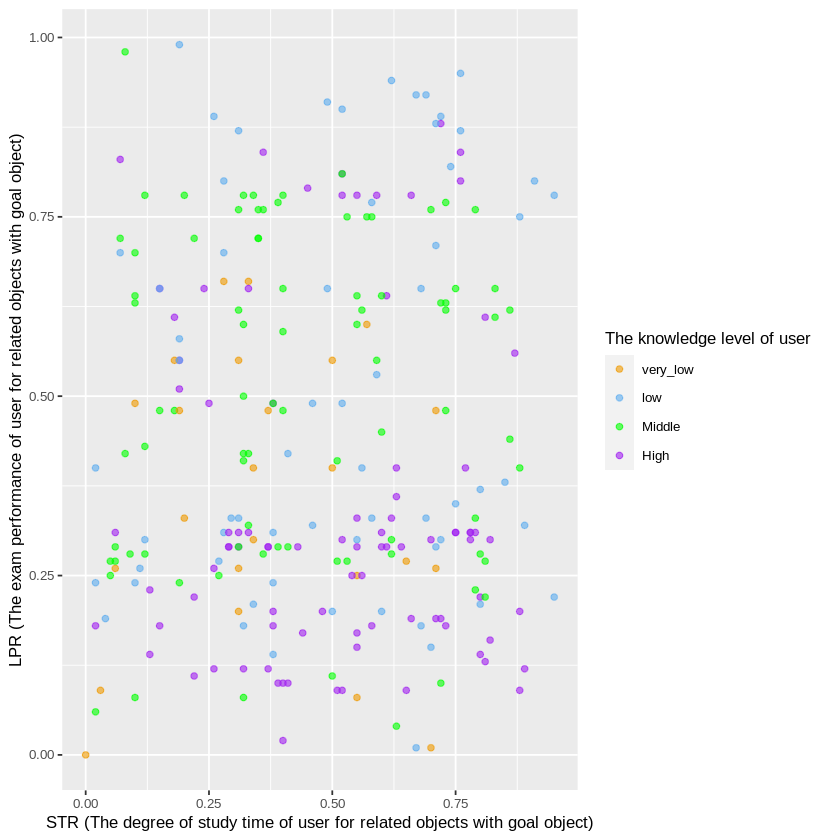

In [7]:
perim_concav_3 <- train %>%
  ggplot(aes( x= STR, y = LPR, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "STR (The degree of study time of user for related objects with goal object)", 
       y = "LPR (The exam performance of user for related objects with goal object)",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 10))
perim_concav_3

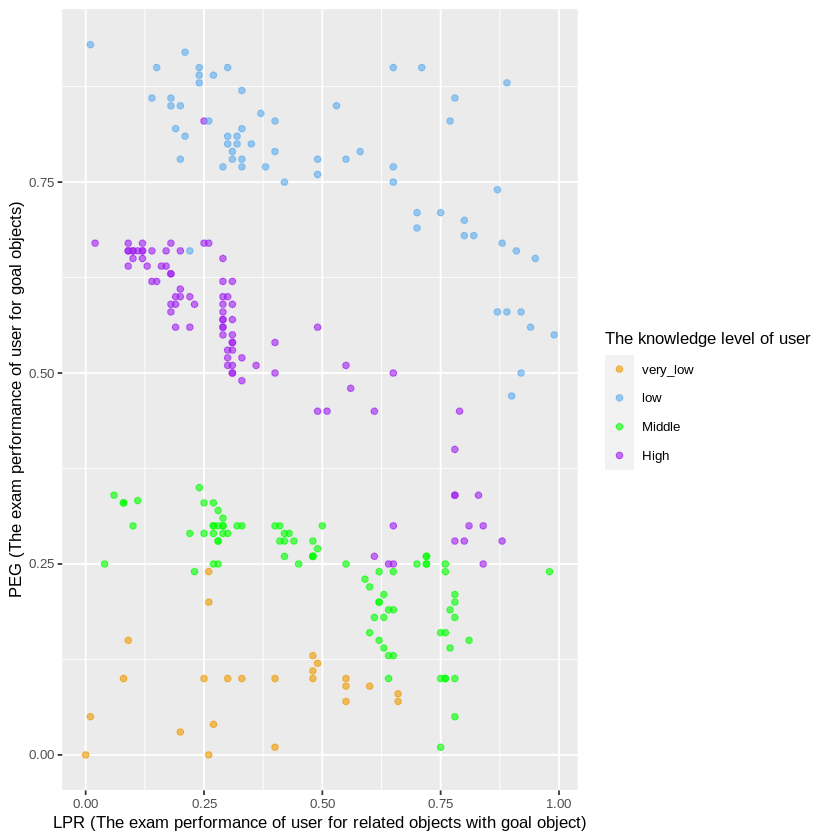

In [8]:
perim_concav_4 <- train %>%
  ggplot(aes(x = LPR, y = PEG, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "LPR (The exam performance of user for related objects with goal object)", 
       y = "PEG (The exam performance of user for goal objects)",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 10))
perim_concav_4

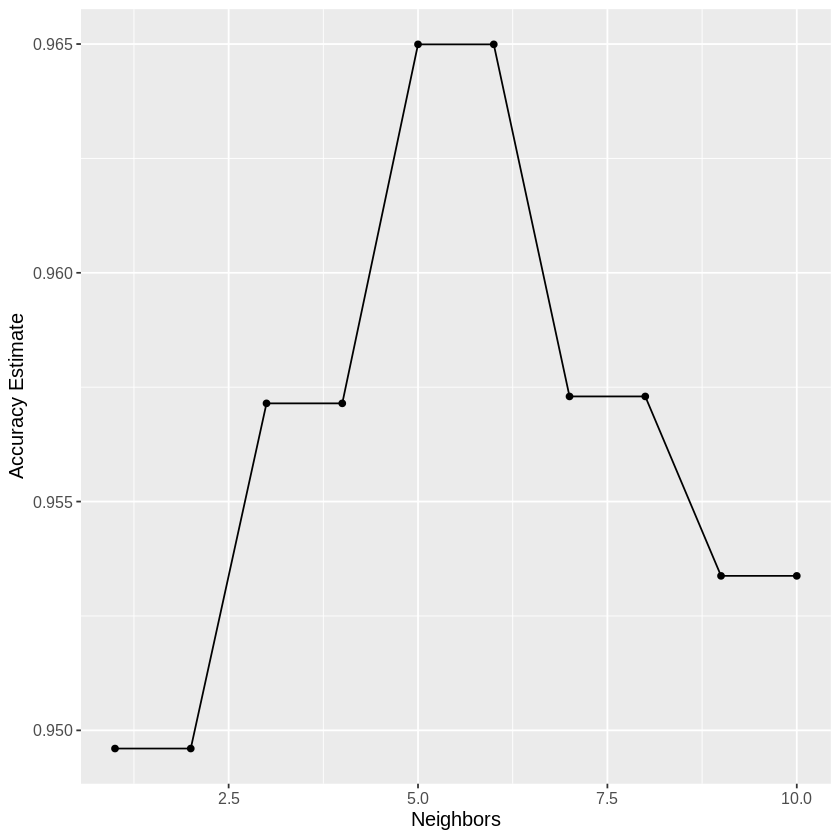

In [17]:
# Set the seed. Don't remove this!
set.seed(9999) 
data_recipe<- recipe(Class ~ LPR + PEG , data = train) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())
##define the model
ks <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

data_vfold <- vfold_cv(train, v = 5, strata = Class)

results <- workflow() %>%
  add_recipe(data_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = data_vfold, grid = ks) %>%
  collect_metrics()

accuracies <- results %>%
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k


In [25]:
#train the model with correct K value and fit the model
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
  set_engine("kknn") %>%
  set_mode("classification")

model_fit<- workflow() %>%
            add_recipe(data_recipe) %>%
            add_model(knn_spec_best) %>%
            fit(data=train)
model_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04263566
Best kernel: rectangular
Best k: 5

In [19]:
test <- read_excel("data/test_data.xlsx") %>% mutate(Class = as_factor(UNS))
test

STG,SCG,STR,LPR,PEG,UNS,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
0.00,0.10,0.50,0.26,0.05,very_low,very_low
0.05,0.05,0.55,0.60,0.14,Low,Low
0.08,0.18,0.63,0.60,0.85,High,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low,Low
0.66,0.68,0.81,0.57,0.57,Middle,Middle
0.68,0.64,0.79,0.97,0.24,Middle,Middle


In [28]:
test_predictions <- predict(model_fit, test) %>%
                    bind_cols(test)
test_predictions

.pred_class,STG,SCG,STR,LPR,PEG,UNS,Class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
very_low,0.00,0.10,0.50,0.26,0.05,very_low,very_low
Low,0.05,0.05,0.55,0.60,0.14,Low,Low
High,0.08,0.18,0.63,0.60,0.85,High,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Low,0.56,0.60,0.77,0.13,0.32,Low,Low
Middle,0.66,0.68,0.81,0.57,0.57,Middle,Middle
Middle,0.68,0.64,0.79,0.97,0.24,Middle,Middle


In [31]:
# get prediction on test
test_predictions %>% 
                    mutate(.pred_class = factor(.pred_class, levels = c("very_low", "Low", "High", "Middle")))%>%
                    metrics(truth = Class, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9724138
kap,multiclass,0.9626192
